<a href="https://colab.research.google.com/github/anastasiia784/Data-Analyst-/blob/main/Python_for_DA_Module_Task_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Analytics Project: Sales and Logistics Analysis of a Global Company

In [3]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/Mate_homework


# ===== LOAD DATASET AND VIEW =====
events_df = pd.read_csv("events.csv")
products_df = pd.read_csv("products.csv")
countries_df = pd.read_csv("countries.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Mate_homework


#Data overview
I load the dataset, understand the contents of the columns, and describe them.
I identify key fields that connect the three tables.

In [4]:

# ====== INITIAL DATA REVIEW ======
# Review events.csv
print("Shape events.csv: ", events_df.shape)
print(events_df.info())
print("\nThe first 5 lines of the events file:\n", events_df.head())

# Review products.csv
print("Shape products.csv: ", products_df.shape)
print(products_df.info())
print("\nThe first 5 lines of the products file:\n", events_df.head())
print("\nUnique categories:\n", products_df['item_type'].unique())

# Overview countries.csv
print("\n--- countries.csv (Країни) ---")
print("Shape countries.csv: ", countries_df.shape)
print(countries_df.info())
print("\nThe first 5 lines of the countries file:\n", countries_df.head())

# Key fields for joining:
# events_df (Country Code) <-> countries_df (alpha-3)
# events_df (Product ID) <-> products_df (id)

Shape events.csv:  (1330, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        1330 non-null   int64  
 1   Order Date      1330 non-null   object 
 2   Ship Date       1330 non-null   object 
 3   Order Priority  1330 non-null   object 
 4   Country Code    1248 non-null   object 
 5   Product ID      1330 non-null   int64  
 6   Sales Channel   1330 non-null   object 
 7   Units Sold      1328 non-null   float64
 8   Unit Price      1330 non-null   float64
 9   Unit Cost       1330 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 104.0+ KB
None

The first 5 lines of the events file:
     Order ID Order Date   Ship Date Order Priority Country Code  Product ID  \
0  100640618  10/8/2014  10/18/2014              M          NOR        2103   
1  100983083  8/11/2016   8/11/2016              C      

#Data cleaning


In [5]:
# ===== DATA CLEANING =====

# events_df Cleaning
# Handling missing values
print("Missing values in events_df before cleaning:\n", events_df.isnull().sum())

# Remove rows where 'Country Code' is missing. The share of missing values is small (about 0.13%),
# and 'Country Code' is critical for geographic analysis.
events_df.dropna(subset=['Country Code'], inplace=True)
events_df.reset_index(drop=True, inplace=True)  # Reset indexes

# Remove rows with missing 'Units Sold'
# Justification: This is a critical field for financial calculations, and the share of missing values is small.
events_df.dropna(subset=['Units Sold'], inplace=True)
events_df.reset_index(drop=True, inplace=True)  # Reset indexes

print("\nMissing values in events_df after removing rows with missing Country Code:\n", events_df.isnull().sum())
print(f"Number of rows after removing missing values: {events_df.shape[0]}")

# Data type correction
events_df['Order Date'] = pd.to_datetime(events_df['Order Date'], errors='coerce')
events_df['Ship Date'] = pd.to_datetime(events_df['Ship Date'], errors='coerce')

# Duplicate check
num_duplicates = events_df.duplicated().sum()
if num_duplicates > 0:
    events_df.drop_duplicates(inplace=True)
    print(f"\nRemoved {num_duplicates} full duplicates.")
else:
    print("\nNo full duplicates found.")

# 3. Text column standardization (convert to uppercase, remove extra spaces)
text_cols = ['Order Priority', 'Country Code', 'Sales Channel']
for col in text_cols:
    events_df[col] = events_df[col].astype(str).str.strip().str.upper()

# 4. Anomaly check (brief overview of numerical data)
print("\nSummary statistics of numerical data in events_df:\n")
print(events_df[['Units Sold', 'Unit Price', 'Unit Cost']].describe())


# products_df Cleaning

# Standardization of item_type (category name)
products_df.rename(columns={'id': 'Product ID', 'item_type': 'Product Category'}, inplace=True)
products_df['Product Category'] = products_df['Product Category'].astype(str).str.strip().str.title()
print("\n\nUnique product categories after standardization:\n", products_df['Product Category'].unique())


# countries_df Cleaning

# Renaming key columns
countries_df.rename(columns={'alpha-3': 'Country Code', 'name': 'Country Name'}, inplace=True)

# Filling missing regions (e.g., for Antarctica)
countries_df['region'] = countries_df['region'].fillna('Undefined')
countries_df['sub-region'] = countries_df['sub-region'].fillna('Undefined')

# Text column standardization (regions, country names)
text_cols_countries = ['Country Name', 'alpha-2', 'Country Code', 'region', 'sub-region']
for col in text_cols_countries:
    countries_df[col] = countries_df[col].astype(str).str.strip()

# Convert region names to Title Case
countries_df['region'] = countries_df['region'].str.title()
countries_df['sub-region'] = countries_df['sub-region'].str.title()

# Check for duplicates by 'Country Code'
num_dup_countries = countries_df['Country Code'].duplicated().sum()
if num_dup_countries > 0:
    countries_df.drop_duplicates(subset=['Country Code'], inplace=True)
    print(f"\nRemoved {num_dup_countries} duplicates in countries_df by Country Code.")
else:
    print("\nNo duplicates found by Country Code.")


Missing values in events_df before cleaning:
 Order ID           0
Order Date         0
Ship Date          0
Order Priority     0
Country Code      82
Product ID         0
Sales Channel      0
Units Sold         2
Unit Price         0
Unit Cost          0
dtype: int64

Missing values in events_df after removing rows with missing Country Code:
 Order ID          0
Order Date        0
Ship Date         0
Order Priority    0
Country Code      0
Product ID        0
Sales Channel     0
Units Sold        0
Unit Price        0
Unit Cost         0
dtype: int64
Number of rows after removing missing values: 1246

No full duplicates found.

Summary statistics of numerical data in events_df:

        Units Sold   Unit Price    Unit Cost
count  1246.000000  1246.000000  1246.000000
mean   4953.186998   264.203387   186.310088
std    2915.825155   216.592937   175.503652
min       2.000000     9.330000     6.920000
25%    2349.250000    81.730000    35.840000
50%    4980.000000   154.060000    97.44

#Data analysis and visualization



In [6]:
# ===== JOINING TABLES AND CREATING METRICS =====

# Creating financial and time-based metrics
events_df['Revenue'] = events_df['Units Sold'] * events_df['Unit Price']
events_df['Cost'] = events_df['Units Sold'] * events_df['Unit Cost']
events_df['Profit'] = events_df['Revenue'] - events_df['Cost']
events_df['Shipping Duration (Days)'] = (events_df['Ship Date'] - events_df['Order Date']).dt.days
events_df.rename(columns={'Order Priority': 'Priority'}, inplace=True)

# Merge events with country information
merged_df = events_df.merge(
    countries_df[['Country Name', 'Country Code', 'region', 'sub-region']],
    how='left',
    on='Country Code'
)

# Merge with product information
final_df = merged_df.merge(
    products_df,
    how='left',
    on='Product ID'
)

# Removing unnecessary columns for final analysis
final_df.drop(columns=['Country Code', 'Product ID'], inplace=True)

print("The final dataframe final_df is ready for analysis.")
print(f"Final dataframe shape: {final_df.shape}")
print("-" * 50)
print(final_df.head())


The final dataframe final_df is ready for analysis.
Final dataframe shape: (1246, 16)
--------------------------------------------------
    Order ID Order Date  Ship Date Priority Sales Channel  Units Sold  \
0  100640618 2014-10-08 2014-10-18        M        ONLINE       650.0   
1  100983083 2016-08-11 2016-08-11        C       OFFLINE      1993.0   
2  102230632 2017-05-13 2017-06-13        L        ONLINE      1171.0   
3  103435266 2012-08-11 2012-09-18        H       OFFLINE      7648.0   
4  103450715 2015-03-15 2015-04-18        H        ONLINE      2220.0   

   Unit Price  Unit Cost     Revenue        Cost     Profit  \
0      205.70     117.11   133705.00    76121.50   57583.50   
1      205.70     117.11   409960.10   233400.23  176559.87   
2      109.28      35.84   127966.88    41968.64   85998.24   
3       47.45      31.79   362897.60   243129.92  119767.68   
4      651.21     524.96  1445686.20  1165411.20  280275.00   

   Shipping Duration (Days) Country Name  reg

In [7]:
# ===== KEY BUSINESS METRICS =====
print("\n\n === KEY BUSINESS METRICS (KPI) ===")

# Metric calculations
total_orders = final_df['Order ID'].nunique()
total_profit = final_df['Profit'].sum()
total_revenue = final_df['Revenue'].sum()
total_countries = final_df['Country Name'].nunique()
total_regions = final_df['region'].nunique()
average_order_value = total_revenue / total_orders
total_units_sold = final_df['Units Sold'].sum()
avg_shipping_duration = final_df['Shipping Duration (Days)'].mean()

metrics = {
    "Total number of unique orders": f"{total_orders:,}",
    "Total profit (USD)": f"${total_profit:,.2f}",
    "Total revenue (USD)": f"${total_revenue:,.2f}",
    "Average order value (AOV)": f"${average_order_value:,.2f}",
    "Total units sold": f"{total_units_sold:,}",
    "Number of countries covered": f"{total_countries}",
    "Number of regions": f"{total_regions}",
    "Average shipping duration (days)": f"{avg_shipping_duration:.2f}"
}

for name, value in metrics.items():
    print(f"- {name}: {value}")




 === KEY BUSINESS METRICS (KPI) ===
- Total number of unique orders: 1,246
- Total profit (USD): $473,709,035.06
- Total revenue (USD): $1,598,983,761.26
- Average order value (AOV): $1,283,293.55
- Total units sold: 6,171,671.0
- Number of countries covered: 45
- Number of regions: 2
- Average shipping duration (days): 24.88


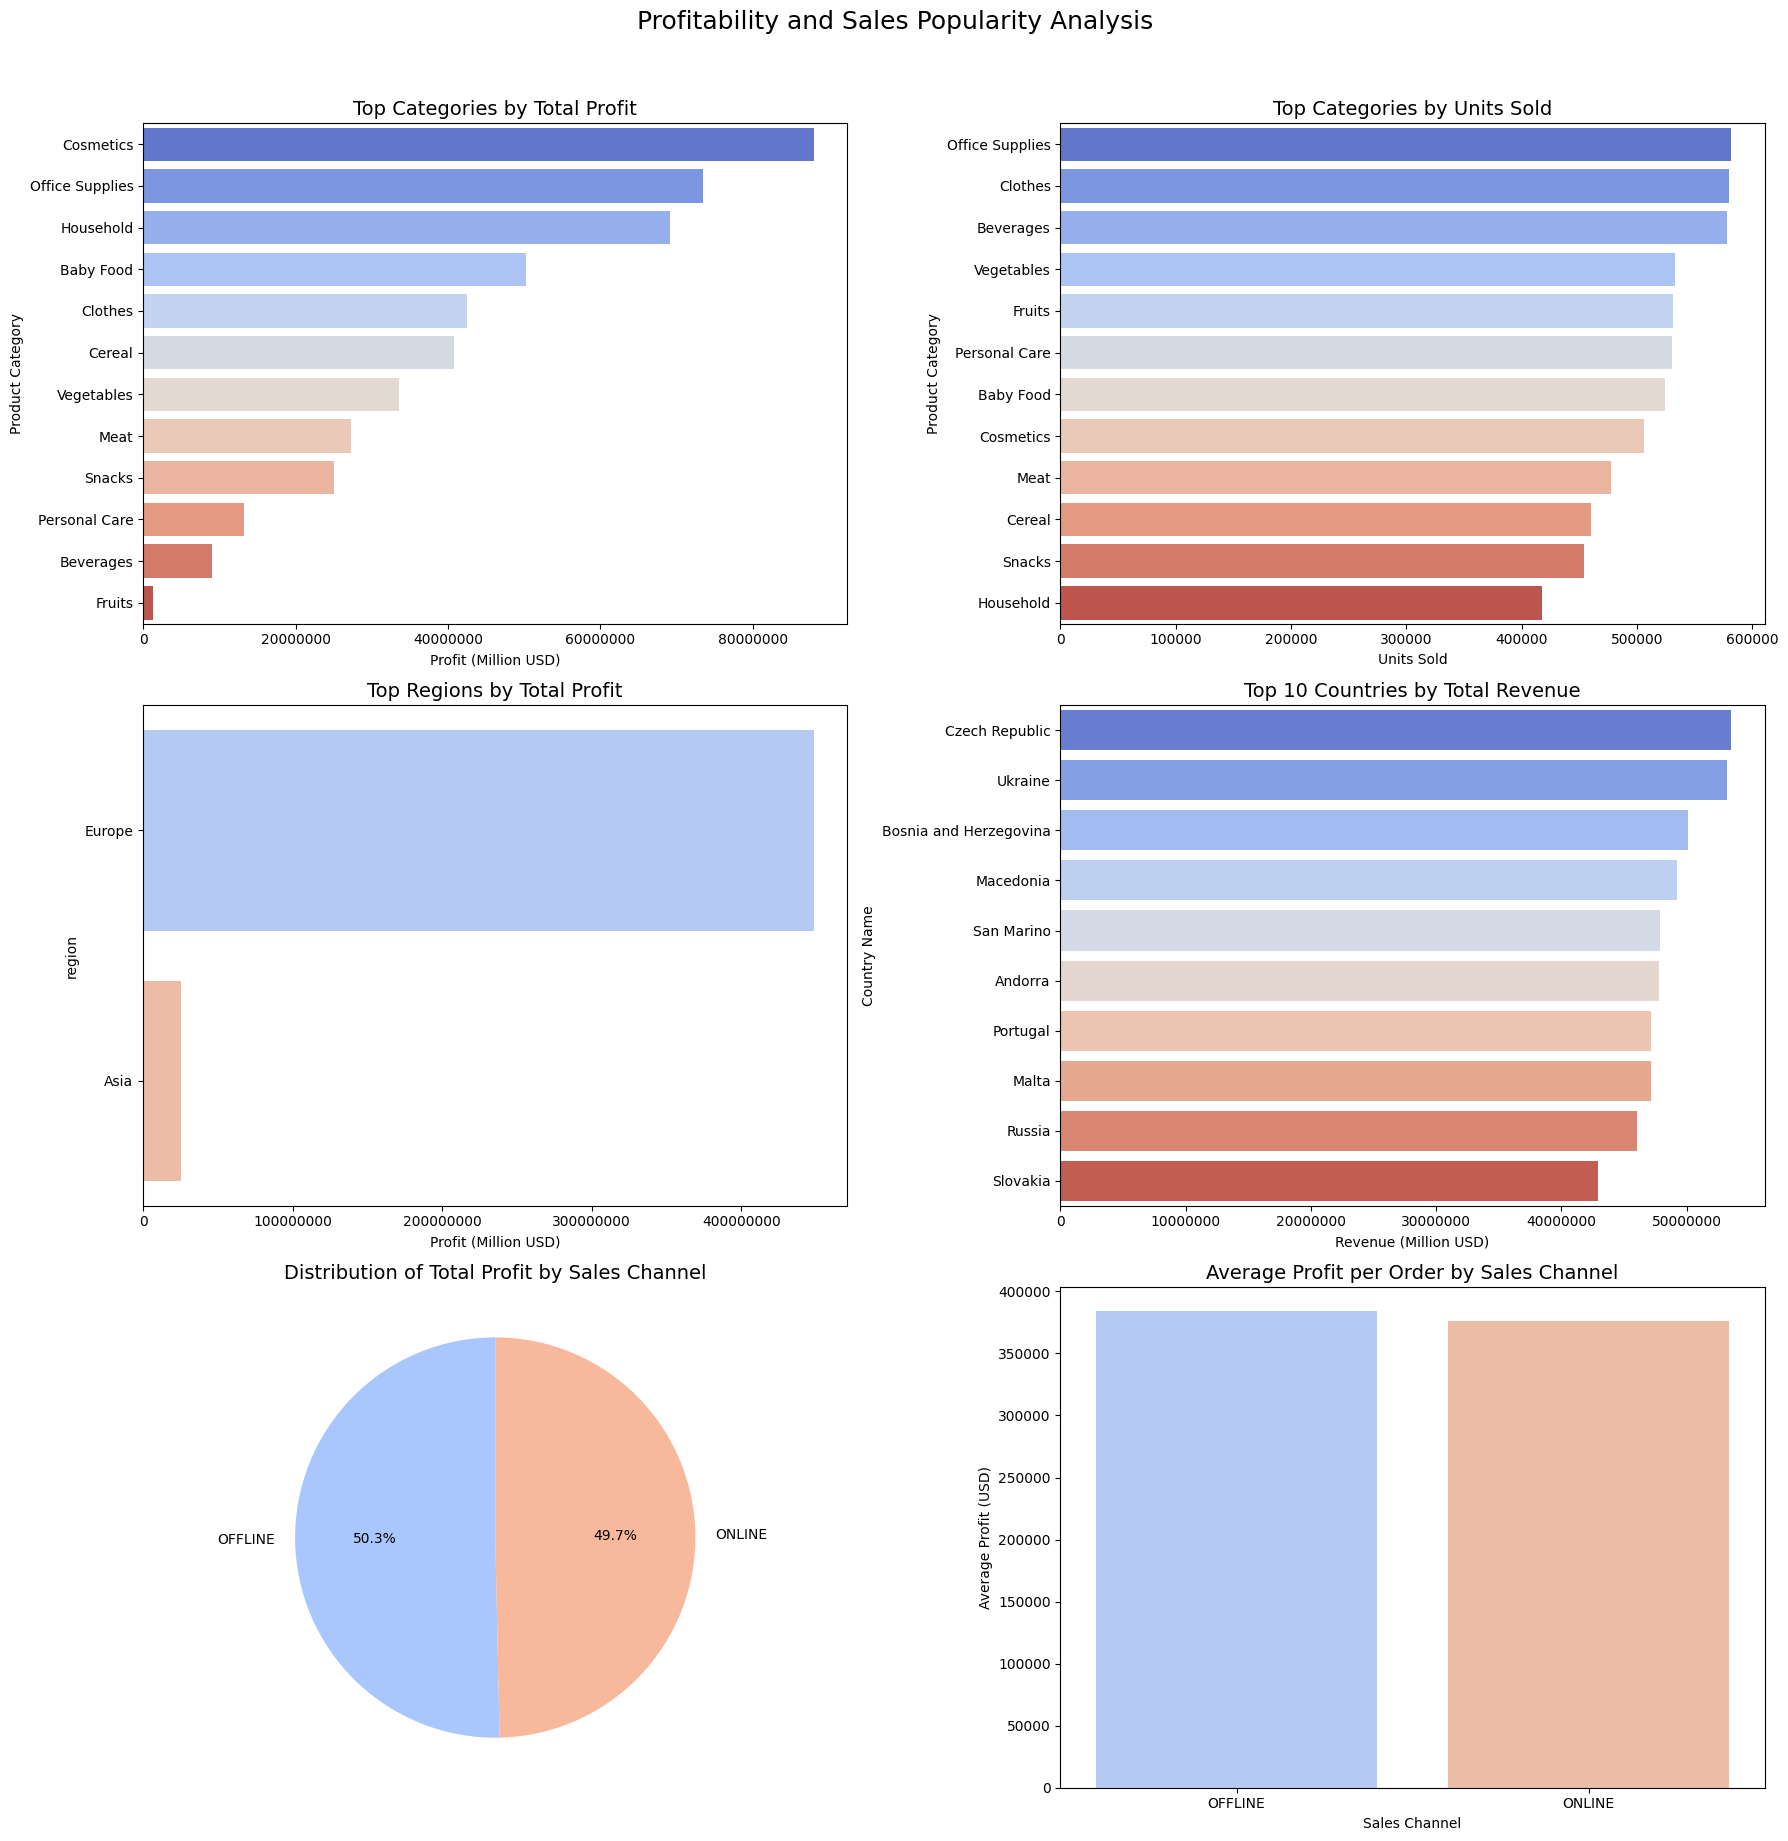

In [9]:
# ===== SALES ANALYSIS AND VISUALIZATION =====

fig, axes = plt.subplots(3, 2, figsize=(18, 18))
plt.suptitle('Profitability and Sales Popularity Analysis', fontsize=18, y=1.02)
UNIFIED_PALETTE = 'coolwarm'
PRIMARY_COLOR = sns.color_palette(UNIFIED_PALETTE)[0]

# ANALYSIS BY PRODUCT CATEGORIES
category_analysis = final_df.groupby('Product Category').agg(
    Total_Profit=('Profit', 'sum'),
    Units_Sold=('Units Sold', 'sum')
).reset_index().sort_values(by='Total_Profit', ascending=False)

# Profit by Category
sns.barplot(
    x='Total_Profit',
    y='Product Category',
    data=category_analysis,
    palette=UNIFIED_PALETTE,
    hue='Product Category',
    ax=axes[0, 0]
)
axes[0, 0].set_title('Top Categories by Total Profit', fontsize=14)
axes[0, 0].set_xlabel('Profit (Million USD)')
axes[0, 0].ticklabel_format(style='plain', axis='x', useOffset=False)

# Popularity by Category (Units Sold)
sns.barplot(
    x='Units_Sold',
    y='Product Category',
    data=category_analysis.sort_values(by='Units_Sold', ascending=False),
    palette=UNIFIED_PALETTE,
    hue='Product Category',
    ax=axes[0, 1]
)
axes[0, 1].set_title('Top Categories by Units Sold', fontsize=14)
axes[0, 1].set_xlabel('Units Sold')
axes[0, 1].ticklabel_format(style='plain', axis='x', useOffset=False)

# ANALYSIS BY GEOGRAPHY (COUNTRIES, REGIONS)
region_analysis = (
    final_df.groupby('region')
    .agg(Total_Profit=('Profit', 'sum'))
    .reset_index()
    .sort_values(by='Total_Profit', ascending=False)
)
country_revenue = (
    final_df.groupby('Country Name')['Revenue']
    .sum()
    .nlargest(10)
    .reset_index()
)

# Profit by Region
sns.barplot(
    x='Total_Profit',
    y='region',
    data=region_analysis,
    palette=UNIFIED_PALETTE,
    hue='region',
    ax=axes[1, 0]
)
axes[1, 0].set_title('Top Regions by Total Profit', fontsize=14)
axes[1, 0].set_xlabel('Profit (Million USD)')
axes[1, 0].ticklabel_format(style='plain', axis='x', useOffset=False)

# Revenue by Top 10 Countries
sns.barplot(
    x='Revenue',
    y='Country Name',
    data=country_revenue,
    palette=UNIFIED_PALETTE,
    hue='Country Name',
    ax=axes[1, 1]
)
axes[1, 1].set_title('Top 10 Countries by Total Revenue', fontsize=14)
axes[1, 1].set_xlabel('Revenue (Million USD)')
axes[1, 1].ticklabel_format(style='plain', axis='x', useOffset=False)

# ANALYSIS BY SALES CHANNELS
channel_analysis = final_df.groupby('Sales Channel').agg(
    Total_Profit=('Profit', 'sum'),
    Total_Orders=('Order ID', 'nunique')
).reset_index()
channel_analysis['Profit_Share'] = (
    channel_analysis['Total_Profit'] / channel_analysis['Total_Profit'].sum()
) * 100
channel_analysis['Avg_Profit_Per_Order'] = (
    channel_analysis['Total_Profit'] / channel_analysis['Total_Orders']
)

# Distribution of Total Profit by Sales Channels (Pie Chart)
pie_colors = sns.color_palette(UNIFIED_PALETTE, n_colors=len(channel_analysis))
axes[2, 0].pie(
    channel_analysis['Profit_Share'],
    labels=channel_analysis['Sales Channel'],
    autopct='%1.1f%%',
    startangle=90,
    colors=pie_colors
)
axes[2, 0].set_title('Distribution of Total Profit by Sales Channel', fontsize=14)
axes[2, 0].set_ylabel('')

# Average Profit per Order by Sales Channel
sns.barplot(
    x='Sales Channel',
    y='Avg_Profit_Per_Order',
    data=channel_analysis,
    palette=UNIFIED_PALETTE,
    hue='Sales Channel',
    ax=axes[2, 1]
)
axes[2, 1].set_title('Average Profit per Order by Sales Channel', fontsize=14)
axes[2, 1].set_xlabel('Sales Channel')
axes[2, 1].set_ylabel('Average Profit (USD)')

plt.tight_layout()
plt.show()


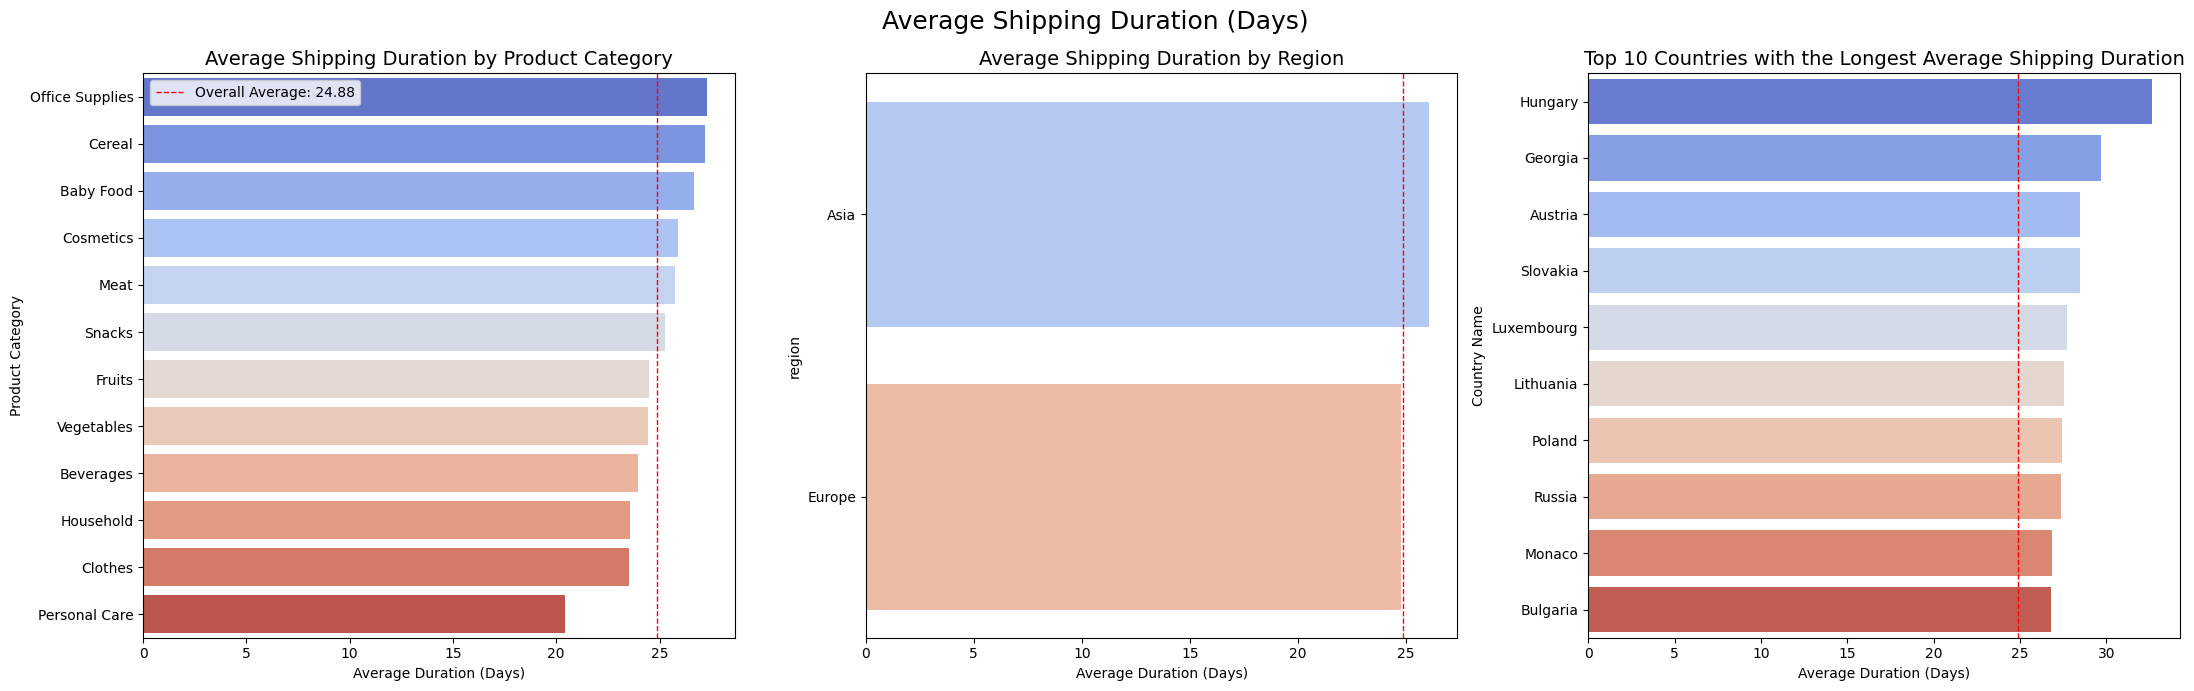


Overall average shipping duration across the dataset: 24.88


In [10]:
# ===== SHIPPING DURATION ANALYSIS =====

events_df['Shipping Duration (Days)'] = (events_df['Ship Date'] - events_df['Order Date']).dt.days
# Overall average shipping duration used as a benchmark line
avg_shipping_duration_total = final_df['Shipping Duration (Days)'].mean()

fig, axes = plt.subplots(1, 3, figsize=(22, 7))
plt.suptitle('Average Shipping Duration (Days)', fontsize=18)

# --- By Product Categories ---
shipping_by_category = (
    final_df.groupby('Product Category')['Shipping Duration (Days)']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    x='Shipping Duration (Days)',
    y='Product Category',
    data=shipping_by_category,
    palette=UNIFIED_PALETTE,
    hue='Product Category',
    ax=axes[0]
)
axes[0].set_title('Average Shipping Duration by Product Category', fontsize=14)
axes[0].set_xlabel('Average Duration (Days)')
axes[0].axvline(
    avg_shipping_duration_total,
    color='red',
    linestyle='--',
    linewidth=1,
    label=f'Overall Average: {avg_shipping_duration_total:.2f}'
)
axes[0].legend()

# --- By Regions ---
shipping_by_region = (
    final_df.groupby('region')['Shipping Duration (Days)']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    x='Shipping Duration (Days)',
    y='region',
    data=shipping_by_region,
    palette=UNIFIED_PALETTE,
    hue='region',
    ax=axes[1]
)
axes[1].set_title('Average Shipping Duration by Region', fontsize=14)
axes[1].set_xlabel('Average Duration (Days)')
axes[1].axvline(
    avg_shipping_duration_total,
    color='red',
    linestyle='--',
    linewidth=1
)

# --- By Countries (Top 10 with the Longest Delivery Time) ---
# Select the top 10 countries with the longest average shipping duration
shipping_by_country = (
    final_df.groupby('Country Name')['Shipping Duration (Days)']
    .mean()
    .nlargest(10)
    .reset_index()
)

sns.barplot(
    x='Shipping Duration (Days)',
    y='Country Name',
    data=shipping_by_country,
    palette=UNIFIED_PALETTE,
    hue='Country Name',
    ax=axes[2]
)
axes[2].set_title('Top 10 Countries with the Longest Average Shipping Duration', fontsize=14)
axes[2].set_xlabel('Average Duration (Days)')
axes[2].axvline(
    avg_shipping_duration_total,
    color='red',
    linestyle='--',
    linewidth=1
)

plt.tight_layout()
plt.show()

print(f"\nOverall average shipping duration across the dataset: {avg_shipping_duration_total:.2f}")


Проаналізуй, чи залежить прибуток від часу, необхідного на відвантаження товару. Зроби потрібні для цього агрегування та візуалізації.

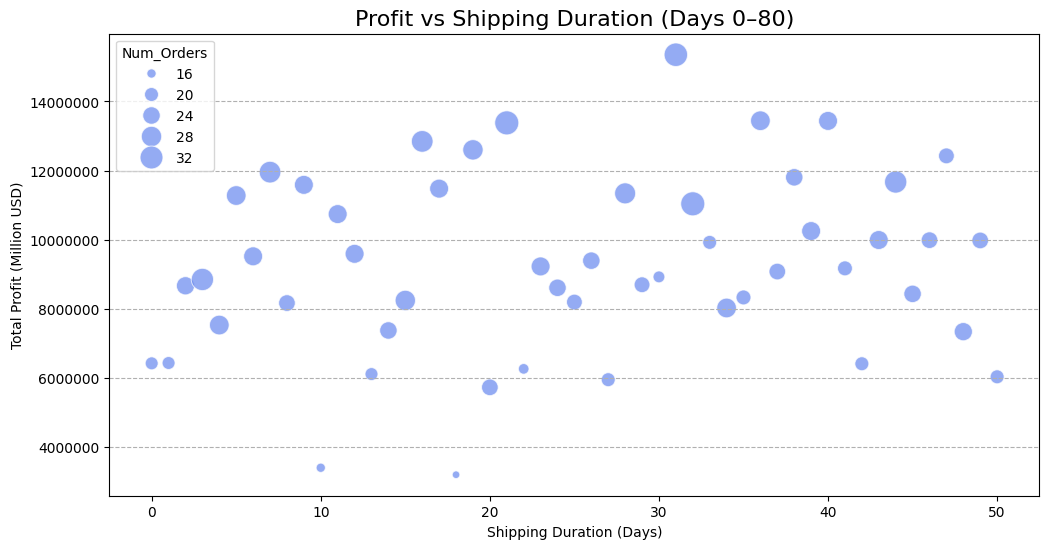


--- Conclusions ---
Pearson correlation coefficient between Profit and Shipping Duration: 0.0607


In [11]:
# ===== AGGREGATION AND CORRELATION CALCULATION =====

# Aggregating profit and number of orders by shipping duration
# This helps avoid an excessive number of points on the chart by grouping data by days.
profit_vs_shipping = final_df.groupby('Shipping Duration (Days)').agg(
    Total_Profit=('Profit', 'sum'),
    Num_Orders=('Order ID', 'nunique')
).reset_index()

# Filtering for better visualization
# We filter out extreme values where data volume may be low,
# making the chart more readable in the range with the highest number of orders.
MAX_DAYS_TO_PLOT = 80
profit_vs_shipping_filtered = profit_vs_shipping[
    profit_vs_shipping['Shipping Duration (Days)'] <= MAX_DAYS_TO_PLOT
]

# Calculating Pearson correlation coefficient (using all data)
correlation_profit_shipping = final_df['Shipping Duration (Days)'].corr(
    final_df['Profit']
)

# VISUALIZATION: PROFIT VS SHIPPING DURATION

plt.figure(figsize=(12, 6))

# Scatter plot
# Point size depends on the number of orders (Num_Orders),
# visually representing the weight of the data.
sns.scatterplot(
    x='Shipping Duration (Days)',
    y='Total_Profit',
    data=profit_vs_shipping_filtered,
    size='Num_Orders',
    sizes=(30, 300),
    alpha=0.7,
    color=PRIMARY_COLOR
)

plt.title(
    f'Profit vs Shipping Duration (Days 0–{MAX_DAYS_TO_PLOT})',
    fontsize=16
)
plt.xlabel('Shipping Duration (Days)')
plt.ylabel('Total Profit (Million USD)')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.grid(True, axis='y', linestyle='--')
plt.show()

# ===== RESULTS =====

print("\n--- Conclusions ---")
print(
    f"Pearson correlation coefficient between Profit and Shipping Duration: "
    f"{correlation_profit_shipping:.4f}"
)


Коефіцієнт кореляції Пірсона між прибутком та тривалістю відвантаження: 0.0607
Оскільки це значення дуже близьке до нуля (0), це означає, що лінійна залежність між прибутком та часом відвантаження є вкрай слабкою або відсутня.



=== SALES DYNAMICS OVER TIME ANALYSIS ===


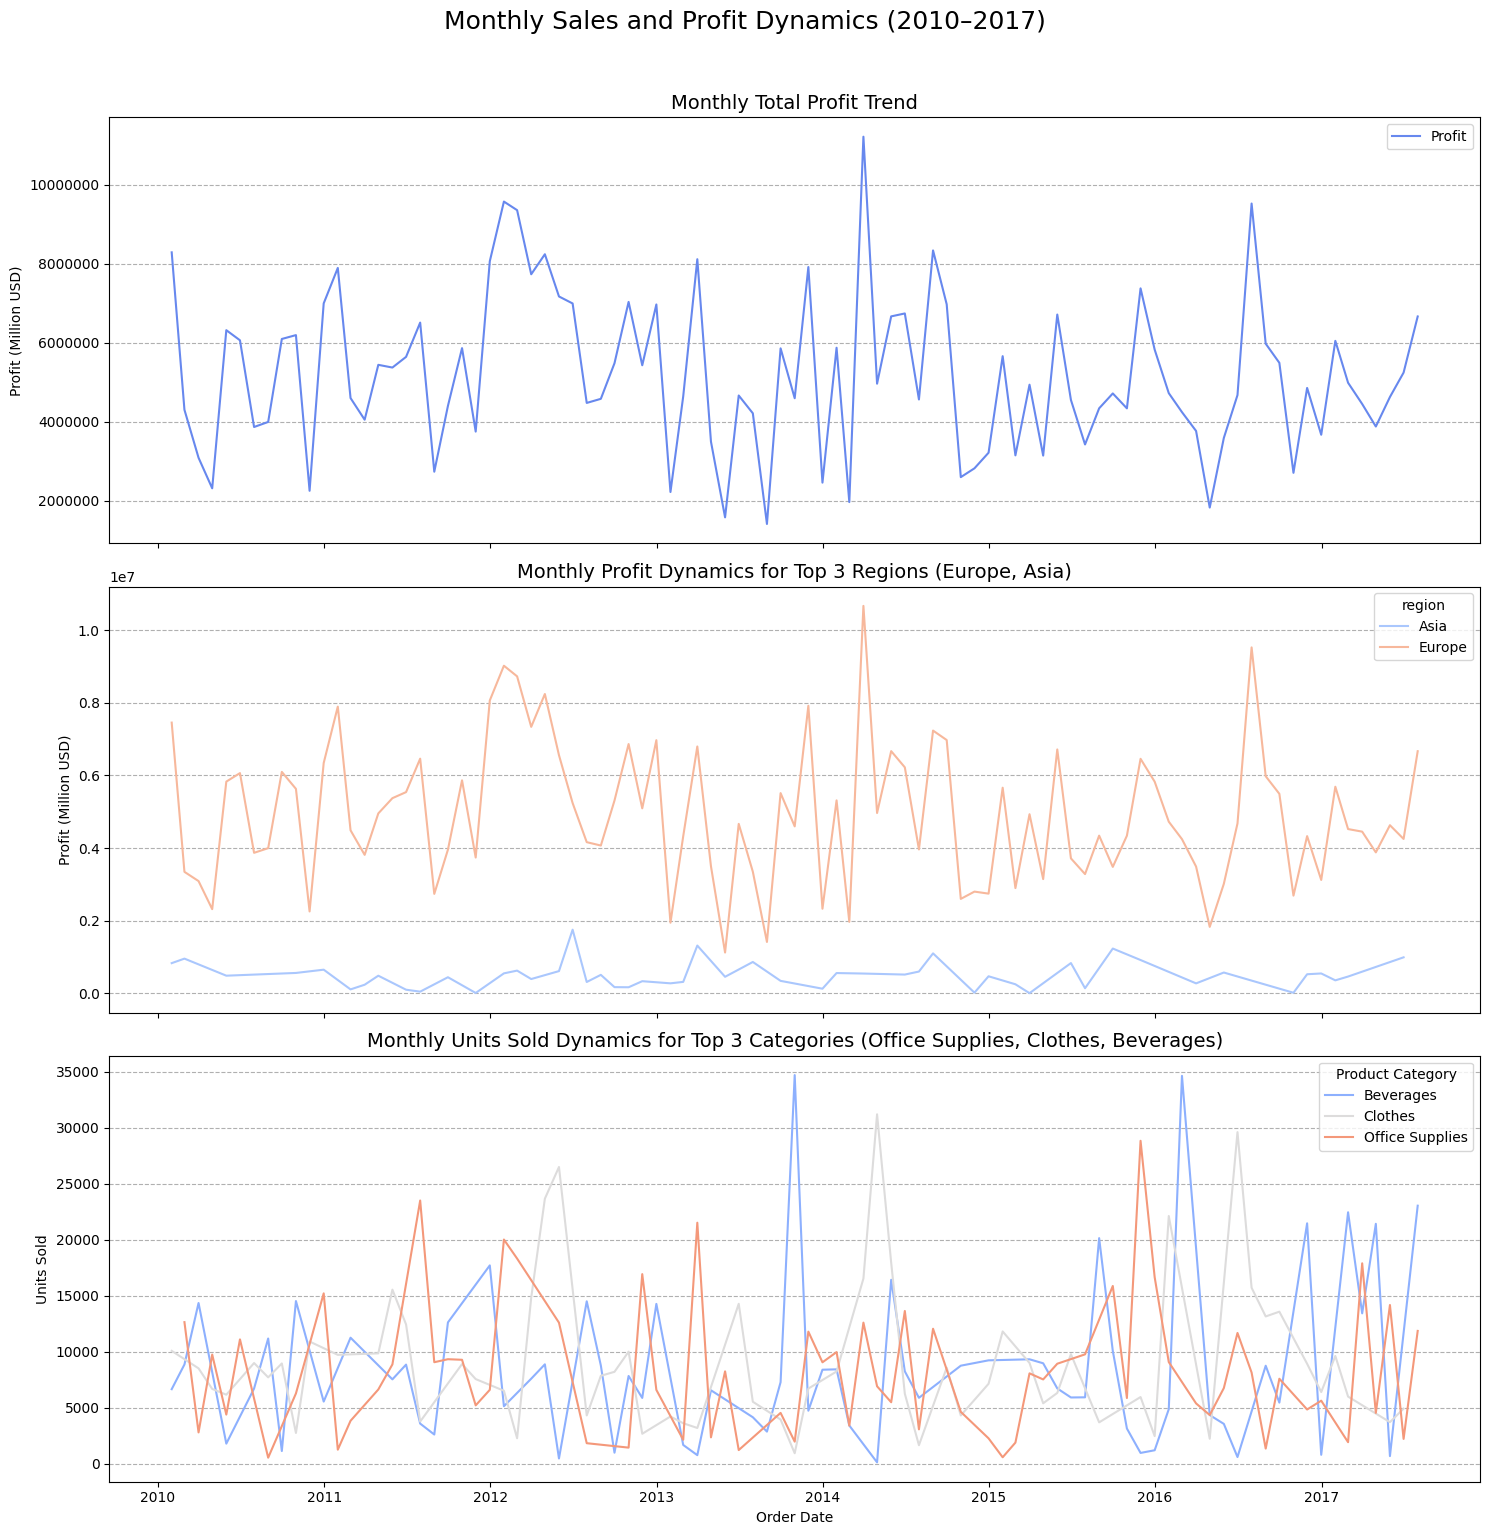

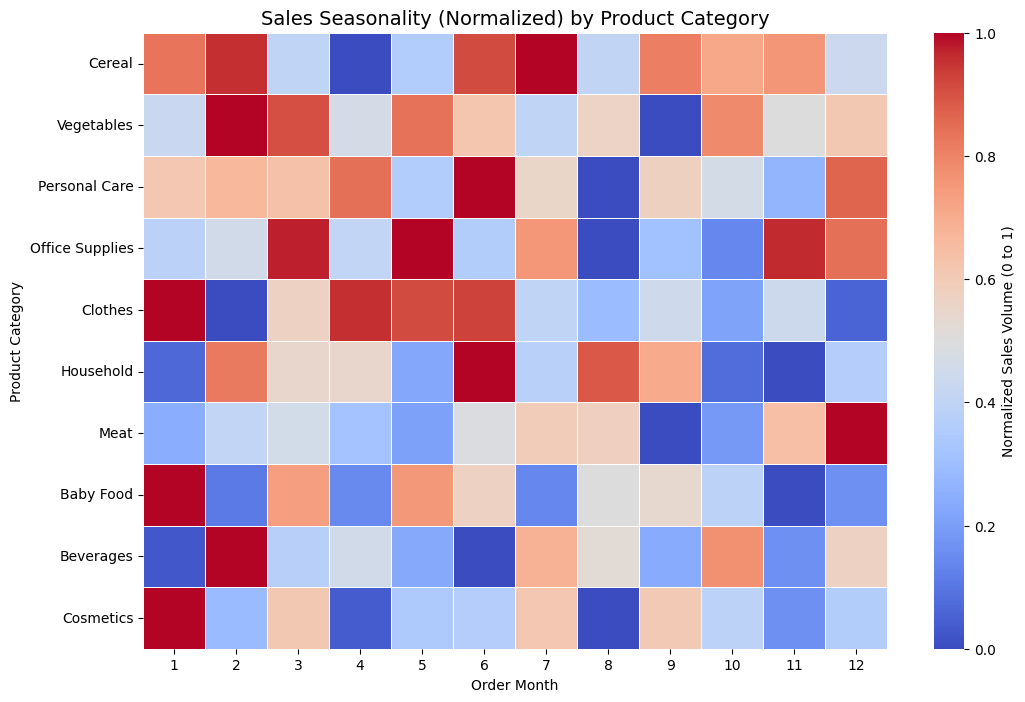

In [12]:
# ===== SALES DYNAMICS OVER TIME ANALYSIS (MONTHLY AGGREGATION) =====

print("\n\n=== SALES DYNAMICS OVER TIME ANALYSIS ===")

# Aggregation of overall metrics by month
time_series_df = (
    final_df.set_index('Order Date')
    .resample('ME')
    .agg(
        Total_Profit=('Profit', 'sum'),
        Total_Orders=('Order ID', 'nunique')
    )
    .reset_index()
)

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
plt.suptitle('Monthly Sales and Profit Dynamics (2010–2017)', fontsize=18, y=1.02)

# Overall Profit Trend
sns.lineplot(
    x='Order Date',
    y='Total_Profit',
    data=time_series_df,
    ax=axes[0],
    color=PRIMARY_COLOR,
    label='Profit'
)
axes[0].set_title('Monthly Total Profit Trend', fontsize=14)
axes[0].set_ylabel('Profit (Million USD)')
axes[0].ticklabel_format(style='plain', axis='y', useOffset=False)
axes[0].grid(True, axis='y', linestyle='--')

# Regional Dynamics (Top 3 Regions by Profit)
top_regions = (
    final_df.groupby('region')['Profit']
    .sum()
    .nlargest(3)
    .index
    .tolist()
)
region_monthly_profit = (
    final_df[final_df['region'].isin(top_regions)]
    .set_index('Order Date')
    .groupby(['region', pd.Grouper(freq='ME')])['Profit']
    .sum()
    .reset_index()
)

sns.lineplot(
    x='Order Date',
    y='Profit',
    hue='region',
    data=region_monthly_profit,
    ax=axes[1],
    palette=UNIFIED_PALETTE
)
axes[1].set_title(
    f'Monthly Profit Dynamics for Top 3 Regions ({", ".join(top_regions)})',
    fontsize=14
)
axes[1].set_ylabel('Profit (Million USD)')
axes[1].grid(True, axis='y', linestyle='--')

# Category Dynamics (Top 3 Categories by Volume)
top_categories = (
    final_df.groupby('Product Category')['Units Sold']
    .sum()
    .nlargest(3)
    .index
    .tolist()
)
category_monthly_units = (
    final_df.set_index('Order Date')
    .groupby(['Product Category', pd.Grouper(freq='ME')])['Units Sold']
    .sum()
    .reset_index()
)

sns.lineplot(
    x='Order Date',
    y='Units Sold',
    hue='Product Category',
    data=category_monthly_units[
        category_monthly_units['Product Category'].isin(top_categories)
    ],
    ax=axes[2],
    palette=UNIFIED_PALETTE
)
axes[2].set_title(
    f'Monthly Units Sold Dynamics for Top 3 Categories ({", ".join(top_categories)})',
    fontsize=14
)
axes[2].set_xlabel('Order Date')
axes[2].set_ylabel('Units Sold')
axes[2].grid(True, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# ===== SEASONALITY ANALYSIS =====

# Identifying seasonality by month for all categories (Heatmap)
final_df['Month'] = final_df['Order Date'].dt.month
monthly_sales = (
    final_df.groupby(['Month', 'Product Category'])['Units Sold']
    .sum()
    .reset_index()
)
monthly_sales_pivot = monthly_sales.pivot_table(
    index='Product Category',
    columns='Month',
    values='Units Sold',
    fill_value=0
)

# Normalization to compare seasonal patterns
monthly_sales_normalized = monthly_sales_pivot.apply(
    lambda x: (x - x.min()) / (x.max() - x.min()),
    axis=1
)

# Select top 10 categories for readability
top_categories_for_heatmap = (
    monthly_sales_normalized.sum(axis=1)
    .nlargest(10)
    .index
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    monthly_sales_normalized.loc[top_categories_for_heatmap],
    cmap=UNIFIED_PALETTE,
    annot=False,
    fmt=".1f",
    linewidths=.5,
    cbar_kws={'label': 'Normalized Sales Volume (0 to 1)'}
)
plt.title('Sales Seasonality (Normalized) by Product Category', fontsize=14)
plt.xlabel('Order Month')
plt.ylabel('Product Category')
plt.yticks(rotation=0)
plt.show()




=== PROFIT ANALYSIS BY DAY OF THE WEEK ===


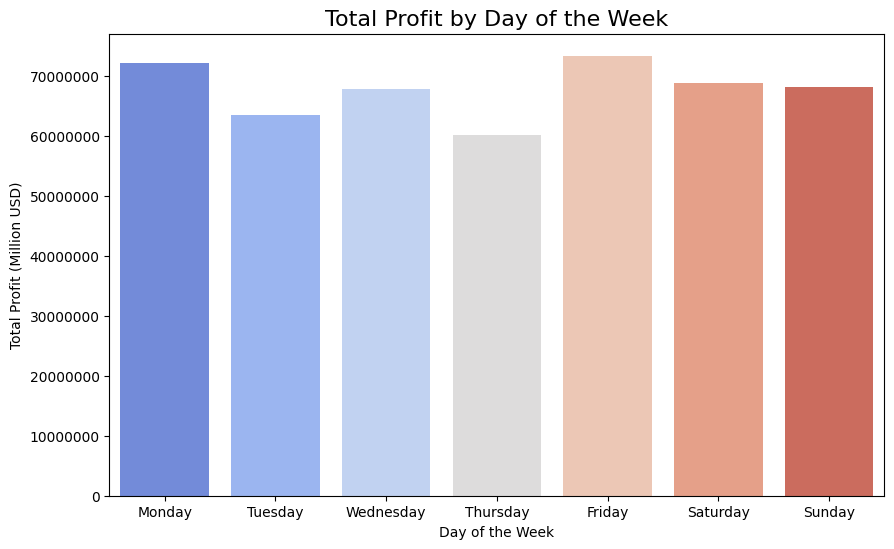

In [13]:
# ===== ANALYSIS BY DAY OF THE WEEK =====

print("\n\n=== PROFIT ANALYSIS BY DAY OF THE WEEK ===")

# Add day-of-week column
final_df['Day of Week'] = final_df['Order Date'].dt.day_name()

# Set the correct order of weekdays
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_df['Day of Week'] = pd.Categorical(
    final_df['Day of Week'],
    categories=day_order,
    ordered=True
)

# Aggregate profit
weekly_profit = (
    final_df.groupby('Day of Week', observed=True)['Profit']
    .sum()
    .reset_index()
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Day of Week',
    y='Profit',
    data=weekly_profit,
    palette=UNIFIED_PALETTE,
    hue='Day of Week'
)
plt.title('Total Profit by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Total Profit (Million USD)')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()


#Reporting

# Key Business Metrics

- **Total number of unique orders:** 1,246

- **Total profit (USD):** $473,709,035.06

- **Total revenue (USD):** $1,598,983,761.26

- **Average Order Value (AOV):** $1,283,293.55

- **Total units sold:** 6,171,671

- **Number of countries covered:** 45

- **Number of regions:** 2

- **Average shipping duration (days):** 24.88


---

# Business Insights Summary

Based on the conducted analysis, the following **key insights** were identified:

## Financial Performance
- **Cosmetics** is the most profitable product category.
- **Office Supply** is the most popular category by sales volume.

## Geographic Priorities
- The **Europe** region generates the highest total profit.
- Marketing and logistics efforts should be prioritized in this region.
- Successful strategies from Europe can be analyzed and replicated in less profitable regions.

## Sales Channels
- The **Online** sales channel is slightly more profitable than the Offline channel.
- The difference between Online and Offline performance is relatively small.

## Logistics (Shipping Duration)
- The average shipping duration is **24.88 days**.
- Profit shows a **weak correlation** with shipping duration (Pearson correlation coefficient close to **0.0**).
- This suggests customers are willing to wait longer when product value and pricing are high.
- Further analysis is recommended for categories and regions with the longest shipping times.

## Trends and Seasonality
- Sales dynamics do not demonstrate a clear long-term growth or decline trend.
- **Day-of-week analysis** shows a relatively uniform distribution of sales.

## Product Seasonality (Heatmap Analysis)
- The heatmap displays **normalized monthly sales volumes** by product category.
- Brighter (red) cells indicate peak sales periods.
- Seasonal patterns are evident in the **top three profit-generating categories**:
  - Cosmetics  
  - Office Supply  
  - Household  
- This highlights the importance of **inventory planning** during peak months.
